# Introduction

## Imports

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
import seaborn as sns

## Env

In [2]:
env = gym.make('Taxi-v3')

## Constants

In [120]:
num_states = env.observation_space.n
num_actions = env.action_space.n  # number of actions plus options

GAMMA = 0.99
ALPHA = 0.8
EPSILON = 0.1

actions = ["south", "north", "east", "west", "pickup", "dropoff"]
color = ["red", "green", "blue", "yellow", "taxi"]
positions = env.unwrapped.locs

## Options

In [121]:
def epsilon_greedy(Q, state):
    if np.random.uniform(0, 1) < EPSILON:
        return np.random.choice(Q.shape[1])
    else:
        return np.argmax(Q[state])

In [140]:
class Option:
    def __init__(self, option_id):
        self.option_id = option_id
        self.policy = np.zeros((num_states, num_actions))
        self.color = color[option_id]
    
    def get_action(self, env, state):
        optact = None
        optdone = False
        x, y, pos, dest = env.unwrapped.decode(state)
        if (x,y) == positions[self.option_id]:
            optdone = True
            optact = 0
        else:
            state_action = self.policy[state]
            state_action = state_action - np.max(state_action)
            exp = np.exp(state_action)
            probs = exp / np.sum(exp)
            optact = np.random.choice(num_actions, p=probs)
        return optact, optdone
    
    def update_policy(self, env, state, action, next_state):
        x_next, y_next, _, _ = env.unwrapped.decode(next_state)
        reward = 0
        if (x_next, y_next) == positions[self.option_id]:
            reward = 40
            # print(self.option_id, " reward")
        else:
            reward = -1
        self.policy[state][action] += ALPHA * (reward + GAMMA * np.max(self.policy[next_state]) - self.policy[state][action])


In [141]:

options = [Option(i) for i in range(4)]

## SMDP

In [142]:
Q_SMDP = np.zeros((num_states, num_actions + 4))
fre_SMDP = np.zeros((num_states, num_actions + 4))
reward_scores = []
for i_episode in range(1000):
    state, _ = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = epsilon_greedy(Q_SMDP, state)

        if action < num_actions:
            next_state, reward, done, trunc, _ = env.step(action)
            done = done or trunc
            score += reward
            steps += 1
            Q_SMDP[state][action] += ALPHA * (reward + GAMMA * np.max(Q_SMDP[next_state]) - Q_SMDP[state][action])
            fre_SMDP[state][action] += 1
            state = next_state


        else:
            option = options[action - num_actions]
            optdone = False
            tau = 0
            reward_bar = 0
            init_state = state
            init_action = action
            while not (optdone or done):
                tau += 1
                optact,optdone = option.get_action(env, state)
                next_state, reward, done, trunc, _ = env.step(optact)
                done = done or trunc
                reward_bar += reward * GAMMA ** tau
                score += reward
                steps += 1
                fre_SMDP[state][action] += 1
                option.update_policy(env, state, optact, next_state)
                optact,optdone = option.get_action(env, next_state)
                state = next_state
            
            estimate = reward_bar + GAMMA**tau * np.max(Q_SMDP[state])
            Q_SMDP[init_state][init_action] += ALPHA * (estimate - Q_SMDP[init_state][init_action])
    reward_scores.append(score)
    if (i_episode + 1) % 100 == 0:
        print(f"Episode {i_episode + 1}, Current Score {score}, Average Score: {sum(reward_scores[-100:])/len(reward_scores[-100:])}, Steps: {steps}")


Episode 100, Current Score -713, Average Score: -689.58, Steps: 200
Episode 200, Current Score -686, Average Score: -637.3, Steps: 200
Episode 300, Current Score -125, Average Score: -331.05, Steps: 83
Episode 400, Current Score 2, Average Score: -99.89, Steps: 19
Episode 500, Current Score -8, Average Score: -23.02, Steps: 29
Episode 600, Current Score -5, Average Score: -7.14, Steps: 17
Episode 700, Current Score -13, Average Score: -3.87, Steps: 16
Episode 800, Current Score 11, Average Score: -0.11, Steps: 10
Episode 900, Current Score 2, Average Score: -6.4, Steps: 19
Episode 1000, Current Score -7, Average Score: -2.1, Steps: 19


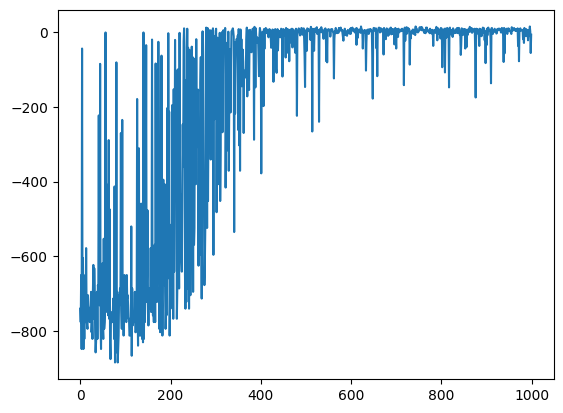

In [143]:
plt.plot([i for i in range(len(reward_scores))], reward_scores)

In [144]:
def plot(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.axhline(y=max(y) if ylabel=='Steps' else min(y), color='r', linestyle='-.')
    plt.text(len(x)//2, max(y) + 3, "Max Value: " + str(max(y)), color='r' if ylabel=='Steps' else 'g')
    
    plt.axhline(y=min(y) if ylabel=='Steps' else max(y), color='g', linestyle='-.')
    plt.text(len(x)//2, min(y) - 20, "Min Value: " + str(min(y)), color='g' if ylabel=='Steps' else 'r')
    plt.show()

ACTION_NAMES = [u"\u2193", u"\u2191", u"\u2192", u"\u2190", 'PICKUP', 'DROPOFF', 'R', 'G', 'Y', 'B']
LOCATIONS = ['RED (0, 0)', 'GREEN (0, 4)', 'YELLOW (4, 0)', 'BLUE (4, 3)']

def plot_heatmap(values, title, ax):
    actions = np.argmax(values, axis=1)
    sns.heatmap(np.max(values, axis=1).reshape(5, 5), annot=np.array([ACTION_NAMES[action] for action in actions]).reshape(5, 5), fmt='', cmap="YlGnBu", ax=ax)
    ax.set_title(title)

def visualize_Q(q_values, start, dest):
    def state_encoder(taxi_row : int, taxi_col : int, passenger_location : int, destination : int) -> int:
        return ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
    pre_pickup_q_values = np.array([q_values[state_encoder(i, j, start, dest)] for i in range(5) for j in range(5)])
    post_pickup_q_values = np.array([q_values[state_encoder(i, j, 4, dest)] for i in range(5) for j in range(5)])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    plot_heatmap(pre_pickup_q_values, "Pre-Pickup", ax1)
    plot_heatmap(post_pickup_q_values, "Post-Pickup", ax2)

    fig.suptitle("Q-values Heatmap for pickup at {} and dropoff at {}".format(LOCATIONS[start], LOCATIONS[dest]))
    plt.show()

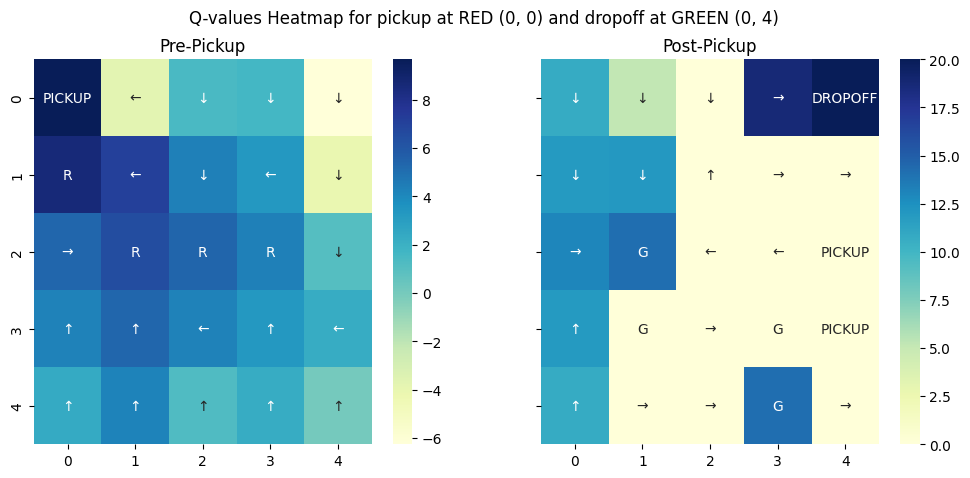

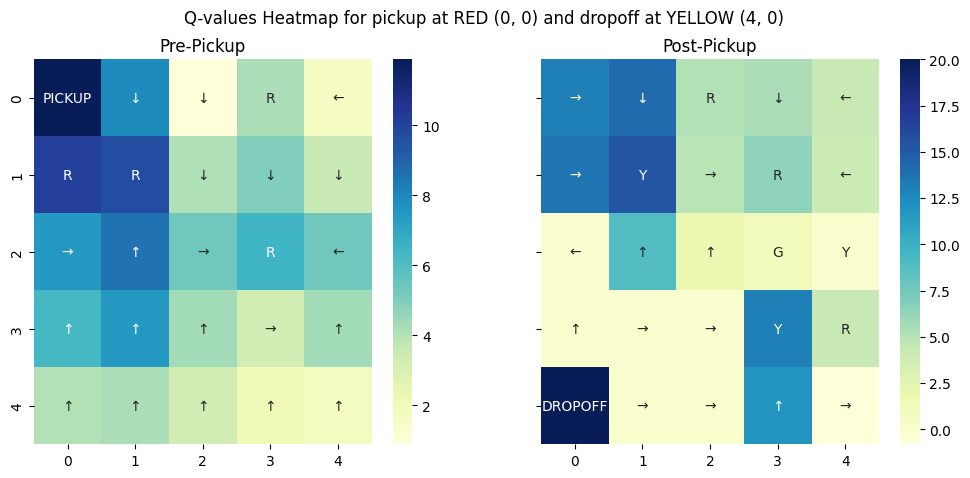

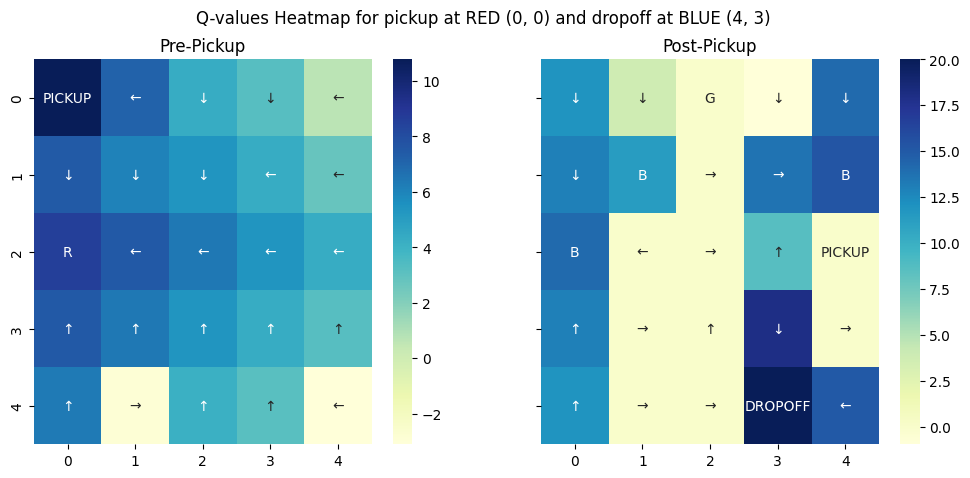

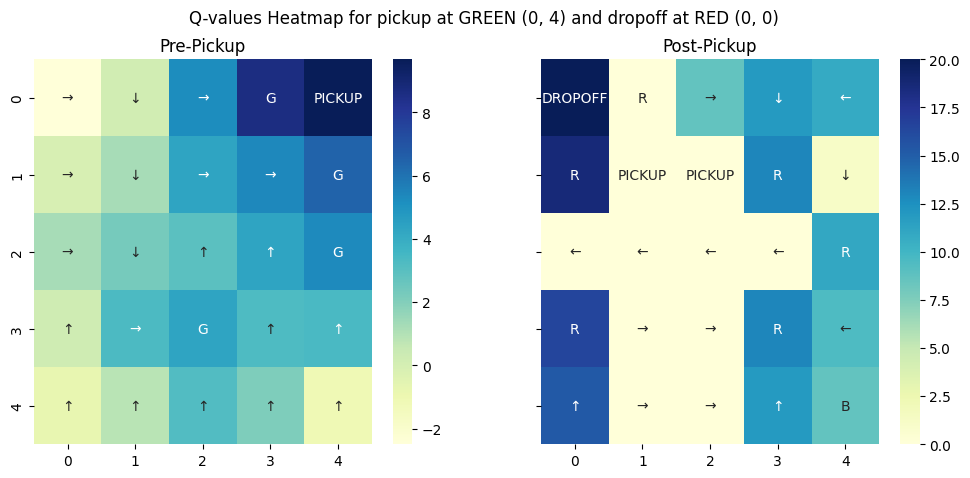

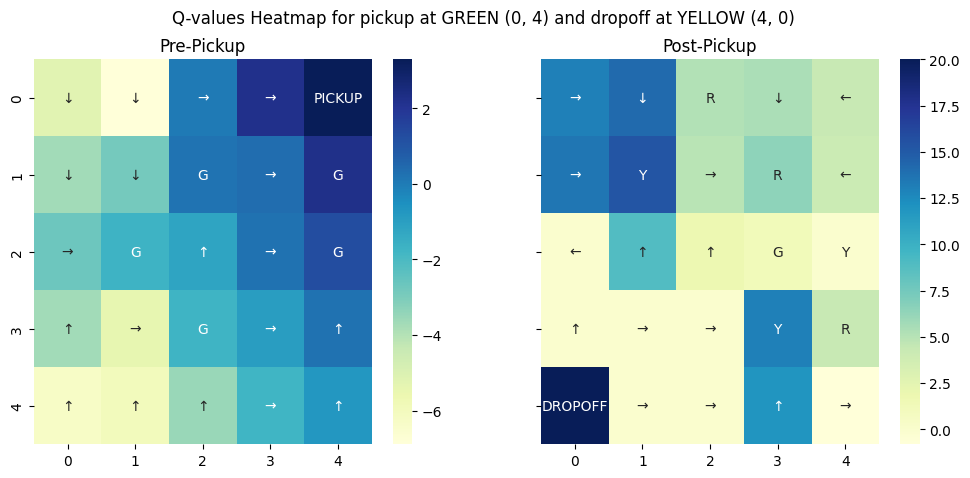

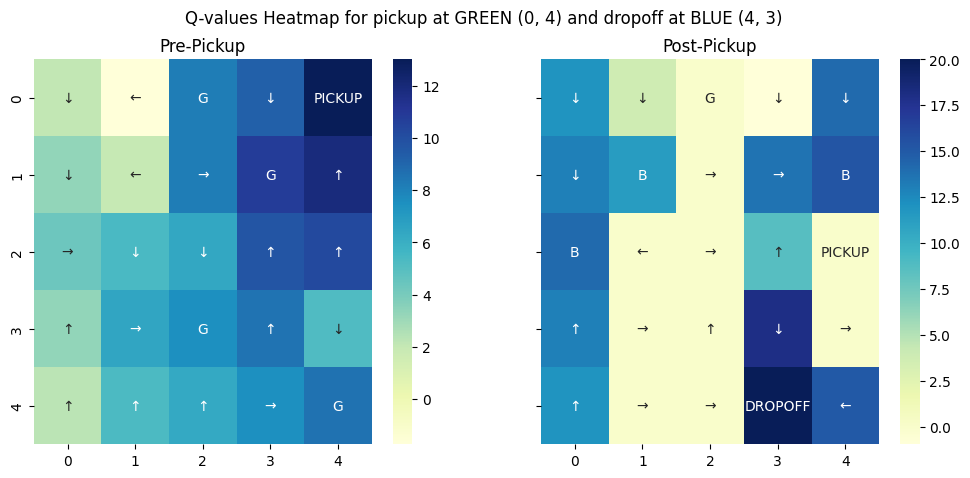

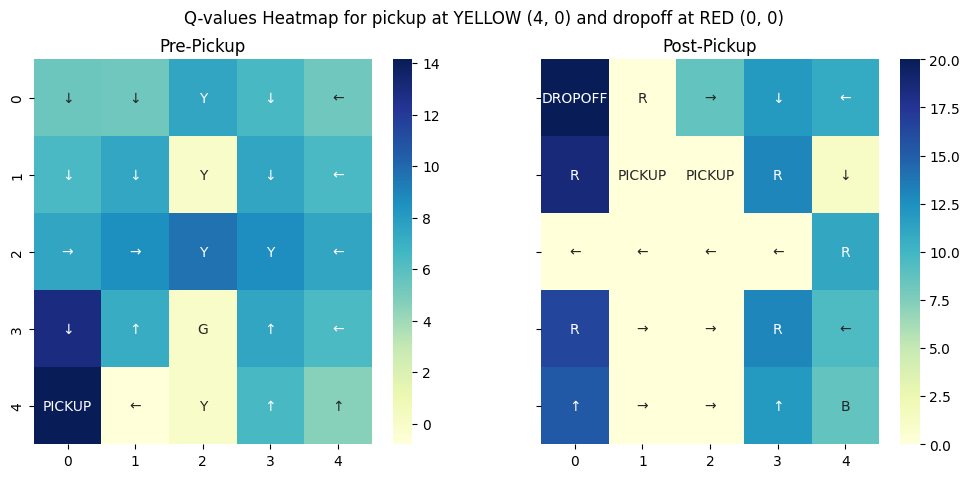

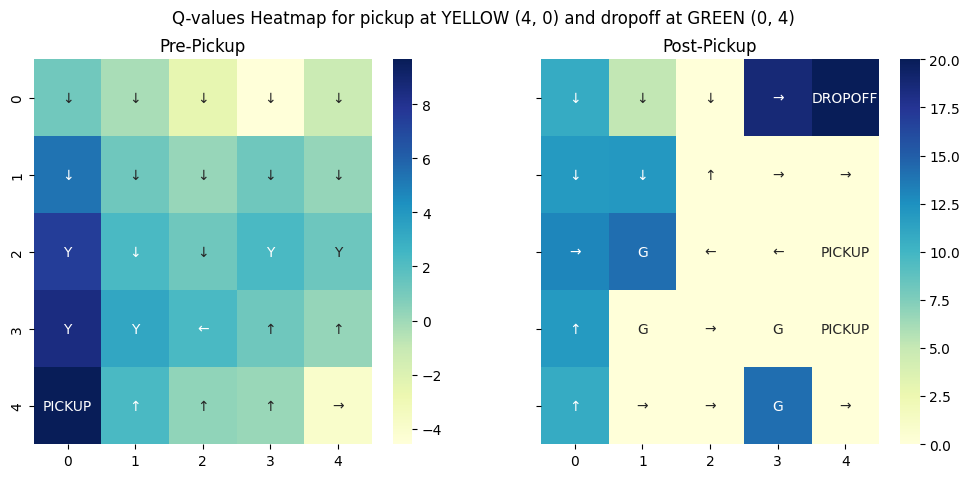

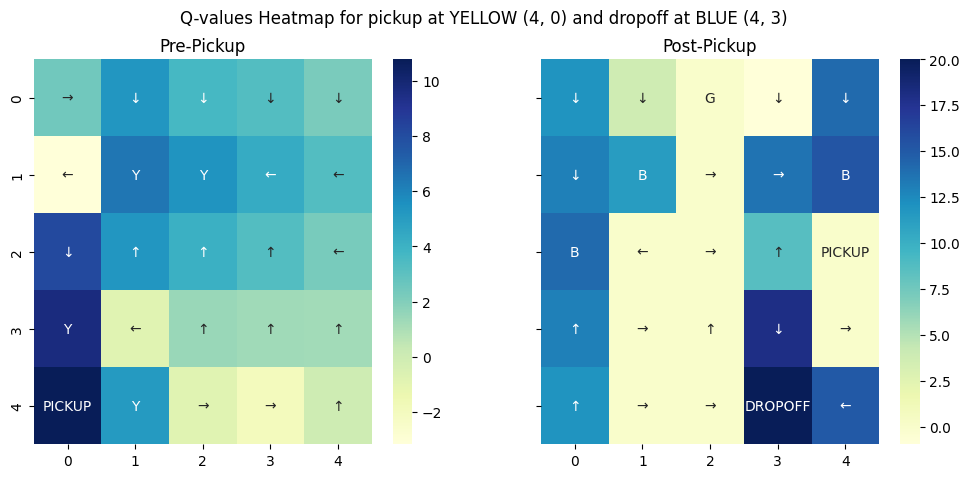

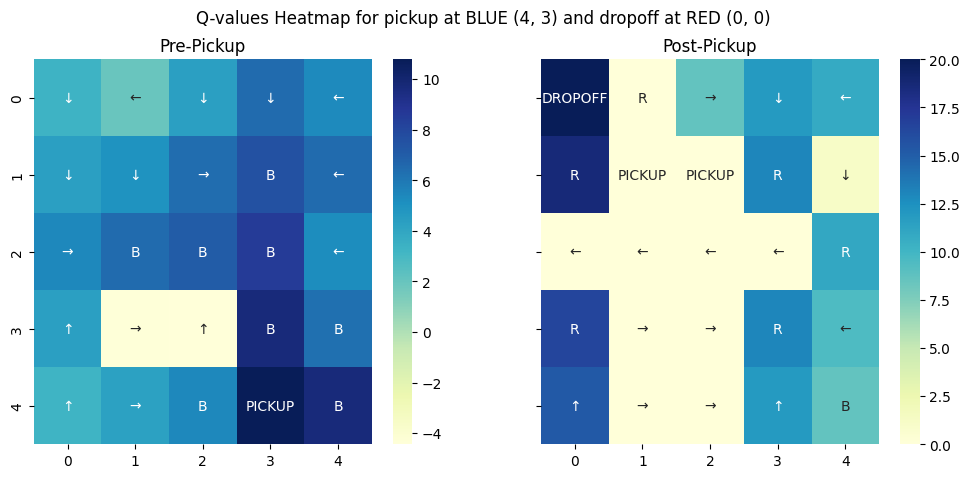

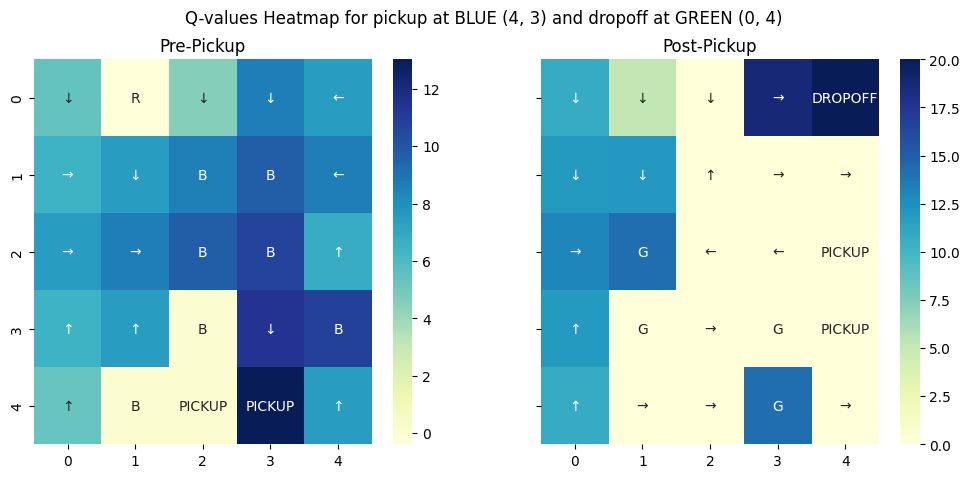

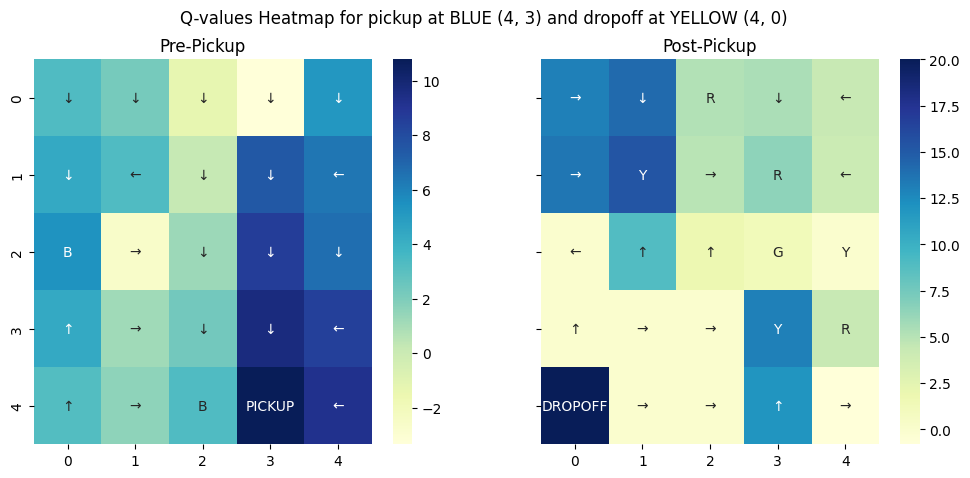

In [146]:
NUM_STARTS = 4
NUM_DESTS = 4

for i in range(NUM_STARTS):
    for j in range(NUM_DESTS):
        if i != j:
            visualize_Q(Q_SMDP, i, j)